# Fit LDA ensemble

see: https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html

In [1]:
#import gensim
#from gensim import corpora
#from gensim.parsing.preprocessing import preprocess_string
#import pandas as pd
#from matplotlib import pyplot as plt 
import pickle
#import numpy as np
    
#%matplotlib inline

In [2]:
import pandas as pd
#import os
#import PyPDF2
#from collections import defaultdict
#from gensim import corpora

from gensim.models import LdaModel
from gensim.models import EnsembleLda
#from gensim.parsing.preprocessing import preprocess_string

import numpy as np
#from random import sample 

In [3]:
from matplotlib import pyplot as plt 

%matplotlib inline

## Load dictionary and corpus
Load the dictionary, tokenized train- and validate-corpus.

In [4]:
with open('../data/dictionary_gw.pickle', 'rb') as handle:
    dictionary_gw = pickle.load(handle)

with open('../data/corpus_train_gw.pickle', 'rb') as handle:
    corpus_train_gw = pickle.load(handle)

with open('../data/corpus_validate_gw.pickle', 'rb') as handle:
    corpus_validate_gw = pickle.load(handle)

## Fit ensemble LDA

### Training

In [29]:
topic_model_class = LdaModel
ensemble_workers = 6
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 100
passes = 2

In [30]:
def fit_ensemble_lda():
    """A function to train an ensemble LDA"""
    ensemble = EnsembleLda(
        corpus=corpus_train_gw,
        id2word=dictionary_gw,
        num_topics=num_topics,
        passes=passes,
        num_models=num_models,
        topic_model_class=topic_model_class,
        ensemble_workers=ensemble_workers,
        distance_workers=distance_workers
    )
    return(ensemble)

### Optimize the epsilon parameter

In [31]:
def get_shape_range(ensemble, steps=25):
    """Get the range of epsilon values for this ensemble"""
    shape = ensemble.asymmetric_distance_matrix.shape
    without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
    return(np.linspace(without_diagonal.min(), without_diagonal.max(), num=steps))

In [26]:
%%time

perplexity = []
max_runs = 5
for run in range(max_runs):
    print(f"Run {run + 1} / {max_runs}")
    eps = []
    num_topics_eps = []
    px = []
    ensemble = fit_ensemble_lda()
    shape_range = get_shape_range(ensemble)
    for val in shape_range:
        ensemble.recluster(eps=val)
        len_topics = len(ensemble.get_topics())
        num_topics_eps.append(len_topics)
        eps.append(val)
        if len_topics > 1:
            # compute the perplexity for this value of epsilon
            log_perplexity = ensemble.log_perplexity(corpus_validate_gw)
            perplexity_eps = np.exp(-log_perplexity)
            px.append(perplexity_eps)
            print(f"eps: {val} stable number of topics: {len_topics}, perplexity: {perplexity_eps}")
        else:
            # there's 1 or no stable topics, perplexity is infinite
            px.append(np.inf)
    perplexity.append(pd.DataFrame.from_dict({'k': num_topics_eps, 'eps': eps, 'val': px}))


Run 1 / 5
eps: 0.08333103623997525 stable number of topics: 2, perplexity: 2607.156495172417
eps: 0.12064513630458457 stable number of topics: 4, perplexity: 1710.4792629504725
eps: 0.15795923636919387 stable number of topics: 3, perplexity: 1660.207631451364
eps: 0.19527333643380318 stable number of topics: 2, perplexity: 1749.9495423752935
eps: 0.2699015365630218 stable number of topics: 2, perplexity: 1688.7397408395088
eps: 0.30721563662763113 stable number of topics: 2, perplexity: 1709.6522420791482
Run 2 / 5
eps: 0.11854690811987965 stable number of topics: 3, perplexity: 1861.3703444994949
eps: 0.15557971647261554 stable number of topics: 3, perplexity: 1672.5213249442709
eps: 0.1926125248253514 stable number of topics: 3, perplexity: 1656.5385351703794
Run 3 / 5
eps: 0.08793568844099464 stable number of topics: 2, perplexity: 2517.6861182445473
eps: 0.12491934628003115 stable number of topics: 3, perplexity: 1744.238138695201
eps: 0.16190300411906766 stable number of topics: 4

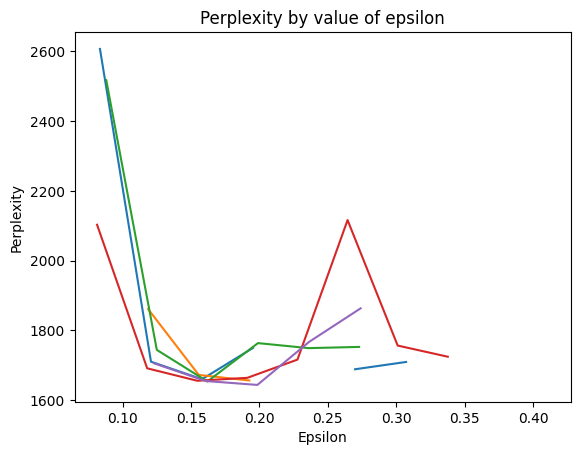

In [28]:
for run in range(max_runs):
    plt.plot(perplexity[run].eps, perplexity[run].val)
plt.title("Perplexity by value of epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

In [52]:
perplexity = [p for p in perplexity if p > -np.inf]
best_eps = eps[perplexity.index(min(perplexity))]

In [53]:
ensemble.recluster(eps=best_eps, min_samples=2, min_cores=2)
print(f"Found {len(ensemble.print_topics())} stable topics")
ensemble.print_topics(num_words=5)

Found 10 stable topics


[(0,
  '0.194*"pulsar" + 0.097*"timing" + 0.053*"array" + 0.023*"millisecond" + 0.015*"ptas"'),
 (1,
  '0.096*"phase" + 0.084*"transition" + 0.026*"order" + 0.020*"model" + 0.019*"bubble"'),
 (2,
  '0.052*"star" + 0.044*"neutrino" + 0.040*"neutron" + 0.025*"collapse" + 0.024*"core"'),
 (3,
  '0.056*"ray" + 0.050*"gamma" + 0.030*"burst" + 0.019*"energy" + 0.017*"emission"'),
 (4,
  '0.026*"equation" + 0.019*"solution" + 0.014*"distance" + 0.014*"field" + 0.011*"general"'),
 (5,
  '0.157*"string" + 0.078*"cosmic" + 0.023*"tension" + 0.022*"background" + 0.018*"asymmetry"'),
 (6,
  '0.047*"lisa" + 0.020*"space" + 0.020*"dwarf" + 0.018*"white" + 0.012*"interferometer"'),
 (7,
  '0.121*"mathrm" + 0.032*"lesssim" + 0.011*"ell" + 0.009*"time" + 0.008*"classification"'),
 (8,
  '0.173*"mode" + 0.032*"polarization" + 0.011*"amplitude" + 0.008*"damping" + 0.008*"frequency"'),
 (9,
  '0.113*"smbh" + 0.033*"rho" + 0.027*"edge" + 0.022*"amplitude" + 0.017*"parameterized"')]